"Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł."

~Aleksandra Wichrowska


## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mptchsz
from mpl_toolkits.mplot3d import Axes3D

## Network topology - rectangular grid

<img src="https://miro.medium.com/max/1000/1*FwvX4R41yciMhBshwpRt4g.png
" alt="drawing" width="300"/>


## Data preparation

In [2]:
def normalize(X):
    return (X-np.mean(X, 0))/np.std(X, 0)

def load_data(file_name, n_col, normalization=True):
    data = pd.read_csv(file_name + '.csv')
    x = data.iloc[:,:n_col]
    x = np.array(x)
    y = data.iloc[:,n_col]
    y = np.array(y)
    if normalization:
        x = normalize(x)
    return x, y

## Plotting data

In [3]:
def plot_2D_data(data, color=[]):
    plt.figure(figsize=(10,6))
    ax = plt.axes()
    ax.set_facecolor('#D3D3D3')
    if len(color) == 0:
        plt.scatter(data[:,0], data[:,1], s=15)
    else:
         plt.scatter(data[:,0], data[:,1], s=15, c=color)
    plt.grid(True)
    plt.show()
    
def plot_3D_data(data, color):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs=data[:,0]
    ys=data[:,1]
    zs=data[:,2]
    ax.scatter(xs, ys, zs, c=color)
    plt.show()

## Self organizing map (Kohonen network) class

In [4]:
class SOM:
    def __init__(self, M, N, input_len, radius=1,distance_type="gauss"):
        
        self.M = M
        self.N = N
        self.shape = (M, N)
        self.input_len = input_len
        
        self.weights = np.random.random([M, N, self.input_len]) 
        
        self.radius = radius
        self.distance_type = distance_type
        
        self.create_grid(M, N)

    def create_grid(self, M, N):
        x = np.linspace(0, N-1, N)
        y = np.linspace(0, M-1, M)
        self.grid_x, self.grid_y = np.meshgrid(x, y)

    def BMU(self, p):
        d_matrix = np.linalg.norm(self.weights - p, axis=2)
        return np.unravel_index(np.argmin(d_matrix), d_matrix.shape)
    
    ######################################################
    ############## NEIGHBOURHOOD FUNCTIONS ###############
    ######################################################   
    
    def lateral_distance(self, BMU):
        distances = np.abs(self.grid_x - BMU[0]) + np.abs(self.grid_y - BMU[1]) 
        return distances

    def gaussian_distance(self, BMU):
        distances = self.lateral_distance(BMU)
        x2 = (distances * self.radius) ** 2
        return np.exp(- x2)

    def mexican_hat_distance(self, BMU):
        distances = self.lateral_distance(BMU)
        x2 = (distances * self.radius) ** 2
        return (2 - 4 * x2) * np.exp(- x2)
    
    ######################################################
    #################### TRAIN NETWORK ###################
    ######################################################
    
    def alpha_t(self):
        return np.exp(-self.t/self.lam)

    def update_weights(self, p, BMU):
        if self.distance_type == "gauss":
            distances = self.gaussian_distance(BMU)
        elif self.distance_type == "mexican":
            distances = self.mexican_hat_distance(BMU)
        distances = distances.reshape([self.M, self.N, 1])
        distances = np.repeat(distances, self.input_len, axis=2)
        self.weights += distances * self.alpha_t() * (p - self.weights)

    def train_epoch(self, x):
        x = np.random.permutation(x)
        for i in range(x.shape[0]):
            p = x[i]
            BMU = self.BMU(p)
            self.update_weights(p, BMU)

    def train(self, x, epochs=100):
        self.lam = epochs
        for i in range(epochs):
            self.t = i+1
            self.train_epoch(x)
            
    ######################################################
    ################### PLOT RESULTS #####################
    ######################################################        
                
    def plot_2D_results(self, data, epochs=10):
        self.train(data, epochs)
        y = self.weights
        plt.figure(figsize=(10,6))
        ax = plt.axes()
        ax.set_facecolor('#D3D3D3')
        plt.scatter(data[:,0], data[:,1], s=15)
        for i in range(0,self.M):
            plt.plot(y[i, 0:self.M, 0], y[i,0:self.M,1], 'ro-')
        for i in range(0,self.N):
            plt.plot(y[0:self.N, i, 0], y[0:self.N, i, 1], 'ro-')
        plt.grid(True)
        plt.show()
        
    # how similiar are neurons to their neighbours
    # dark color means close connection
    def plot_umatrix(self):
        w = self.weights
        u_matrix = np.zeros(shape=self.shape, dtype=np.float64)
        for i in range(self.M):
            for j in range(self.N):
                v = w[i][j]  # a vector 
                sum_dists = 0.0; ct = 0
                if i-1 >= 0:    # above
                    sum_dists += np.linalg.norm(v - w[i-1][j])
                    ct += 1
                if i+1 <= self.M-1:   # below
                    sum_dists += np.linalg.norm(v - w[i+1][j])
                    ct += 1
                if j-1 >= 0:   # left
                    sum_dists += np.linalg.norm(v - w[i][j-1])
                    ct += 1
                if j+1 <= self.N-1:   # right
                    sum_dists += np.linalg.norm(v - w[i][j+1])
                    ct += 1  
                u_matrix[i][j] = sum_dists/ct
        ax = plt.axes()
        ax.set_aspect('equal')
        plt.imshow(u_matrix, cmap='gray')  
        plt.show()
            
    ######################################################
    ############### PLOT DENSITY MAPS ####################
    ######################################################
    
    # Following plots and visualizations are inspired by https://github.com/alexarnimueller/som
    # and implemented on my own
                
    # how many times each neuron is a BMU    
    def winner_map(self, data):
        winner_map = np.zeros(self.shape, dtype=int)
        for d in data:
            [x, y] = self.BMU(d)
            winner_map[x, y] += 1
        return winner_map

    
    def plot_density_map(self, data, colormap='gist_yarg', plot=True):

        fig, ax = plt.subplots(figsize=[self.N, self.M])

        winner_map = self.winner_map(data)
        plt.pcolormesh(winner_map, cmap=colormap, edgecolors=None)
        
        #ax.set_xlim([0, self.M])
        #ax.set_ylim([0, self.N])
        plt.xticks(np.arange(.5, self.M + .5), range(self.M))
        plt.yticks(np.arange(.5, self.N + .5), range(self.N))
        ax.set_aspect('equal')

        if not plot:
            return fig, ax
        plt.show()

    def plot_point_map(self, data, targets, targetnames, colors):

        fig, ax = self.plot_density_map(data, plot=False)
        
        for index, point in enumerate(data):
            c = colors[targets[index]]
            w = self.BMU(point)
            ax.plot(w[1] + .5 + 0.1 * np.random.randn(1), w[0] + .5 + 0.1 * np.random.randn(1),
                    'o', color=c, markersize=15)

        ax.grid(which='both')
        plt.show()

## Hexagon data

In [5]:
x,y = load_data('hexagon',2)

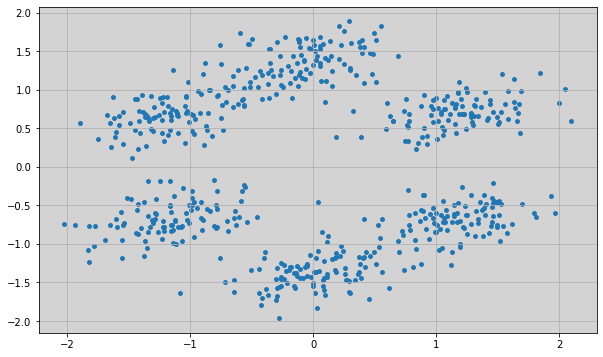

In [6]:
plot_2D_data(x)

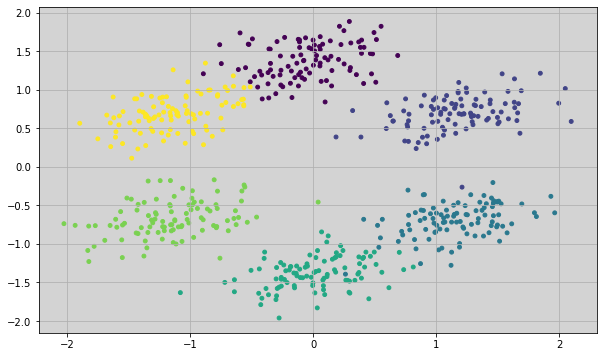

In [7]:
plot_2D_data(x,y)

### Neurons connection after 1000 epochs of training for 10x10 network

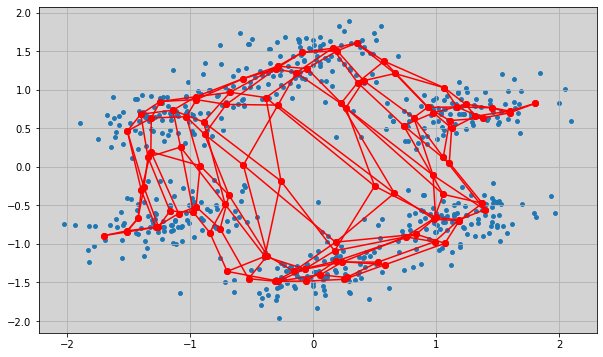

In [8]:
net = SOM(10,10,2)
net.plot_2D_results(x,1000)

### Neurons density plot after 100 epochs of training for 10x10 network

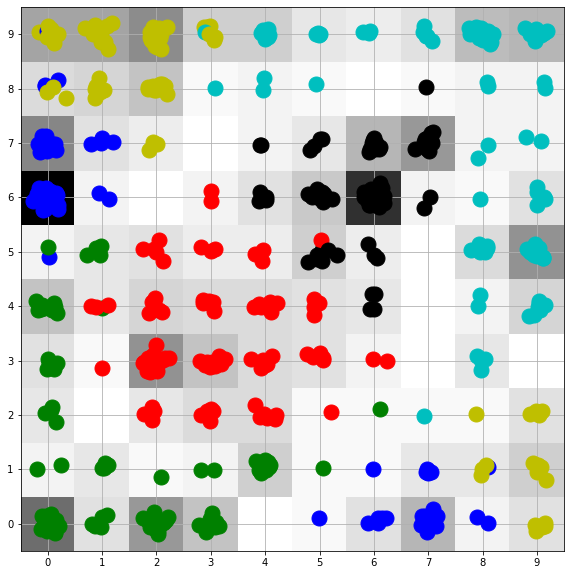

In [9]:
data, classes = load_data("hexagon", 2)

network = SOM(10, 10, 2, radius=0.5, distance_type="gauss")
network.train(data, epochs=100)
network.plot_point_map(data, classes, ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], colors=['r', 'g', 'b', 'y', 'c', 'k'])

### U-matrix after 2000 epochs of training for 20x20 network

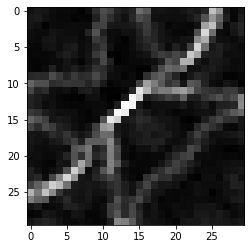

In [10]:
network = SOM(30, 30, 2, radius=1, distance_type="gauss")
network.train(data, epochs=2000)
network.plot_umatrix()

## Cube data

In [11]:
x,y = load_data('cube',3)

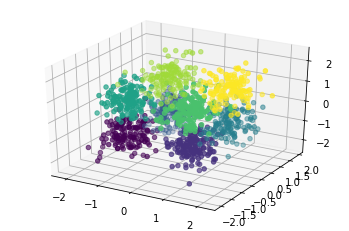

In [12]:
plot_3D_data(x,y)

### Neurons density plot after 500 epochs of training for 15x15 network

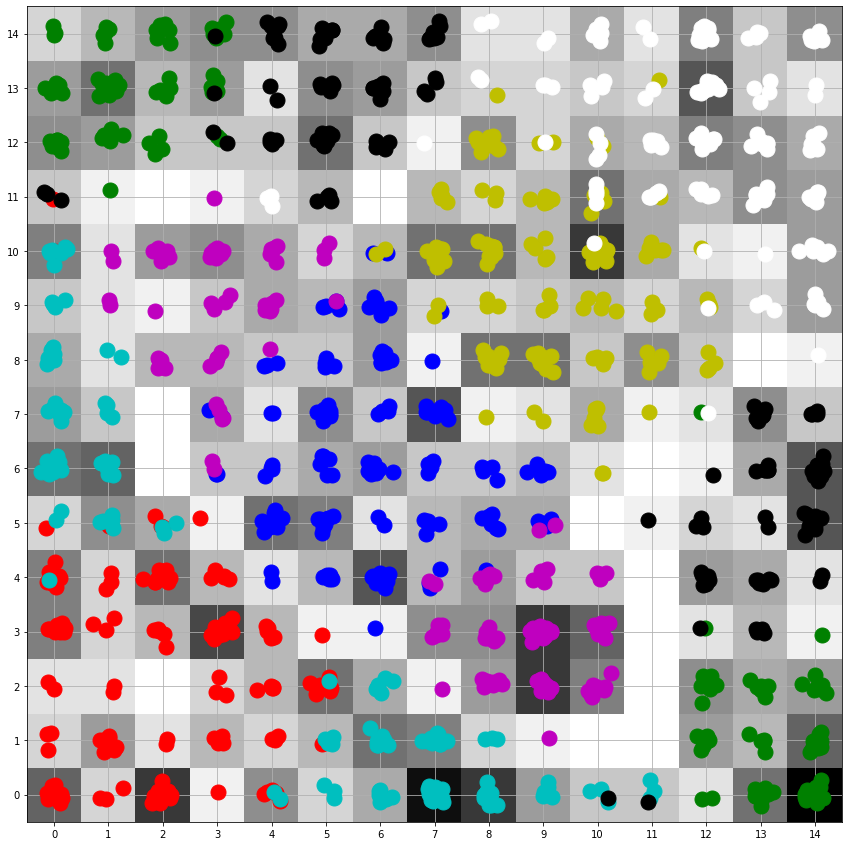

In [13]:
network = SOM(15, 15, 3, radius=0.8, distance_type="gauss")
network.train(x, epochs=500)
network.plot_point_map(x, y, ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], colors=['r', 'g', 'b', 'y', 'c', 'k', 'm', 'w' ])